# O que é e como estimar o Beta de uma ação usando o Python

O beta, também conhecido como coeficiente beta (β), é uma medida que quantifica a sensibilidade de um ativo financeiro em relação às variações do mercado como um todo. Em outras palavras, o beta indica o grau de volatilidade de um ativo em relação ao movimento de um índice de referência.

Neste artigo, vamos explorar em detalhes o funcionamento do coeficiente beta e demonstrar como obtê-lo utilizando um conjunto de dados do mercado acionário brasileiro. Utilizaremos a linguagem de programação Python como ferramenta para construção e análise.


## Modelo de Índice Único

Empiricamente foi observado no mercado acionário que, quando o mercado sobe (mensurado por um índice de bolsa de valores), a maioria das ações tende a aumentar o preço e, quando o mercado cai, a maioria das ações vê seu preço diminuir. Isso sugere o motivo da correlação entre as ações, que deriva do fato que há uma resposta comum a mudanças de mercado.

O retorno de uma ação pode ser escrito como:

$$R_i = \alpha_i + \beta_i R_m + e_i$$

- $R_i$: Retorno do ativo

- $\alpha_i$: Representa o valor esperado do retorno não oriundo do mercado

- $R_m$: Retorno do índice de mercado

- $\beta_i$: mede a mudança esperada em R_i dada uma mudança em R_m

- $e_i$: é o componente aleatório que afeta os retornos.

## CAPM

O Modelo de Precificação de Ativos (CAPM) estabelece uma relação sistemática de precificação de ações, a partir da concepção da arbitragem de risco entre o retorno esperado de um ativo financeiro e seu risco sistêmico, medido pelo famoso coeficiente beta (β). A formulação do CAPM foi indenpendente da resolução do modelo de índice única, apesar da semelhança. O CAPM é formulado pela seguinte equação:

$$ E(R_i) = R_f + \beta_i (E(R_m) - R_f) $$

- $E(R_i)$: Retorno esperado do ativo.
- $R_f$: Taxa livre de risco (geralmente baseada em títulos do governo).
- $\beta_i$: Coeficiente beta do ativo, que mede seu risco sistemático em relação ao mercado.
- $E(R_m)$: Retorno esperado do mercado.
- $E(R_m) - R_f$: Prêmio de risco de mercado.

## Beta

- Um ativo com $ \beta = 1 $ é considerado tão volátil quanto o mercado. Isso significa que, em média, ele se move na mesma direção e na mesma proporção que o mercado.

- Um ativo com $ \beta > 1 $ é considerado mais volátil que o mercado. Isso significa que, em média, ele tende a ter movimentos maiores do que o mercado.

- Um ativo com $ \beta < 1 $ é considerado menos volátil que o mercado. Isso significa que, em média, ele tende a ter movimentos menores do que o mercado.

- Um ativo com $ \beta = 0 $ é considerado não relacionado ao mercado. Isso significa que seus retornos são independentes dos movimentos do mercado.

Podemos estimar o Beta a partir da seguinte fórmula:

$$ \beta = \frac{{\text{Covariância}(R_i, R_m)}}{{\text{Variância}(R_m)}} $$

Assim, podemos obter a estimativa pela forma manual, calculando a covariância e a variância, ou usando funções para o cálculo do MQO.

# Estimando o Beta no Python

Para obter a estimativa do Beta necessitamos de retornos dos ativos, do retorno de mercado e um taxa representa a taxa livre de risco. Aqui usaremos quatro ações para definir um portfólio teórico com pesos iguais ('BBDC4.SA', 'ITSA4.SA', 'VALE3.SA', 'WEGE3.SA'). Usaremos o retorno do Ibovespa como retorno de mercado e o CDI como taxa livre de risco. Os dados compreendem o período de jan/2014 até dez/2023 em periodicidade mensal.

# Bibliotecas

In [ ]:
!pip install python-bcb

In [ ]:
from bcb import sgs
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

## Gráficos
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [ ]:
start = '2014-01-01' # início
end = '2023-12-31' # fim

# CDI

In [ ]:
# CDI acumulada no mês (%a.m)
cdi_m = sgs.get({'cdi' : 4391}, start = start)

In [ ]:
cdi_m

,cdi
Date,
2014-01-01,0.84
2014-02-01,0.78
2014-03-01,0.76
2014-04-01,0.82
2014-05-01,0.86
...,...
2023-10-01,1.00
2023-11-01,0.92
2023-12-01,0.89


# Retorno do Ibovespa

In [ ]:
# Preços Históricos
precos = yf.download('^BVSP', start = start, end = end, interval = '1mo')

# Calcula Retornos Mensais
returns = (
          precos[['Adj Close']]
          .pct_change()
          .rename(columns = {'Adj Close' : 'retornos_ibov'})
          .dropna()
          )

[*********************100%%**********************]  1 of 1 completed


In [ ]:
returns

,retornos_ibov
Date,
2014-02-01,-0.011440
2014-03-01,0.070519
2014-04-01,0.024021
2014-05-01,-0.007496
2014-06-01,0.037647
...,...
2023-08-01,-0.050852
2023-09-01,0.007111
2023-10-01,-0.029348


In [ ]:
# Junta os data frames
returns_rf =  (
    returns.merge(cdi_m, left_index = True, right_index = True)
    .assign(cdi = lambda x: x.cdi / 100)
    )

In [ ]:
returns_rf

,retornos_ibov,cdi
Date,,
2014-02-01,-0.011440,0.0078
2014-03-01,0.070519,0.0076
2014-04-01,0.024021,0.0082
2014-05-01,-0.007496,0.0086
2014-06-01,0.037647,0.0082
...,...,...
2023-08-01,-0.050852,0.0114
2023-09-01,0.007111,0.0097
2023-10-01,-0.029348,0.0100


# Ativo

In [ ]:
# Tickers dos ativos
assets = ['BBDC4.SA', 'ITSA4.SA', 'VALE3.SA', 'WEGE3.SA']

# Baixa os dados (dados mensais)
precos_ativos = yf.download(assets, start = start, end = end, interval = '1mo')
precos_ativos = precos_ativos.loc[:,('Adj Close', slice(None))]
precos_ativos.columns = assets

# Calculando os retornos
Y = precos_ativos[assets].pct_change().dropna()

# Verifica os retornos
Y.head()

[*********************100%%**********************]  4 of 4 completed


,BBDC4.SA,ITSA4.SA,VALE3.SA,WEGE3.SA
Date,,,,
2014-02-01,0.043960,0.009941,-0.001513,0.116423
2014-03-01,0.152414,0.092089,-0.047879,0.045728
2014-04-01,0.065903,0.059276,-0.059516,0.106489
2014-05-01,-0.059888,-0.038343,-0.009714,-0.033445
2014-06-01,0.027544,0.016374,0.027407,0.087658


In [ ]:
# Número de ativos
num_ativos = len(Y.columns)

# Calcula pesos iguais
peso_por_ativo = 1.0 / num_ativos
ewp = [peso_por_ativo] * num_ativos

# Pesos
ewp

[0.25, 0.25, 0.25, 0.25]

In [ ]:
# Calcula o retorno do portfólio
portfolio_returns_ewp = pd.DataFrame((Y * ewp).sum(axis = 1), columns = ['portfolio_ewp'])
portfolio_returns_ewp

,portfolio_ewp
Date,
2014-02-01,0.042203
2014-03-01,0.060588
2014-04-01,0.043038
2014-05-01,-0.035348
2014-06-01,0.039746
...,...
2023-08-01,-0.077085
2023-09-01,0.005065
2023-10-01,-0.030043


In [ ]:
# Junta os dados
portfolio = (
            portfolio_returns_ewp
            .merge(returns_rf, left_index = True, right_index = True)
            )

portfolio.head()

,portfolio_ewp,retornos_ibov,cdi
Date,,,
2014-02-01,0.042203,-0.011440,0.0078
2014-03-01,0.060588,0.070519,0.0076
2014-04-01,0.043038,0.024021,0.0082
2014-05-01,-0.035348,-0.007496,0.0086
2014-06-01,0.039746,0.037647,0.0082


# Excesso de Retorno

In [ ]:
# Calcula o excesso de retorno do portfólio
portfolio['excesso_retorno'] = portfolio['portfolio_ewp'] - portfolio['cdi']

# Calcula o excesso de retorno do mercado
portfolio['excesso_ibovespa'] = portfolio['retornos_ibov'] - portfolio['cdi']

portfolio.head()

,portfolio_ewp,retornos_ibov,cdi,excesso_retorno,excesso_ibovespa
Date,,,,,
2014-02-01,0.042203,-0.011440,0.0078,0.034403,-0.019240
2014-03-01,0.060588,0.070519,0.0076,0.052988,0.062919
2014-04-01,0.043038,0.024021,0.0082,0.034838,0.015821
2014-05-01,-0.035348,-0.007496,0.0086,-0.043948,-0.016096
2014-06-01,0.039746,0.037647,0.0082,0.031546,0.029447


# Regressão Linear

In [ ]:
# Cria um modelo de regressão linear via MQO
model_fit = (smf.ols(
    formula = "excesso_retorno ~ excesso_ibovespa", # fórmula
    data = portfolio) # dados
  .fit() # realiza o ajuste
)

# Verifica o resultado do modelo
model_fit_coefs = model_fit.summary(slim = True).tables[1]
print(model_fit_coefs)

                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0069      0.003      2.596      0.011       0.002       0.012
excesso_ibovespa     0.9124      0.040     22.867      0.000       0.833       0.991


# Gráfico de Dispersão

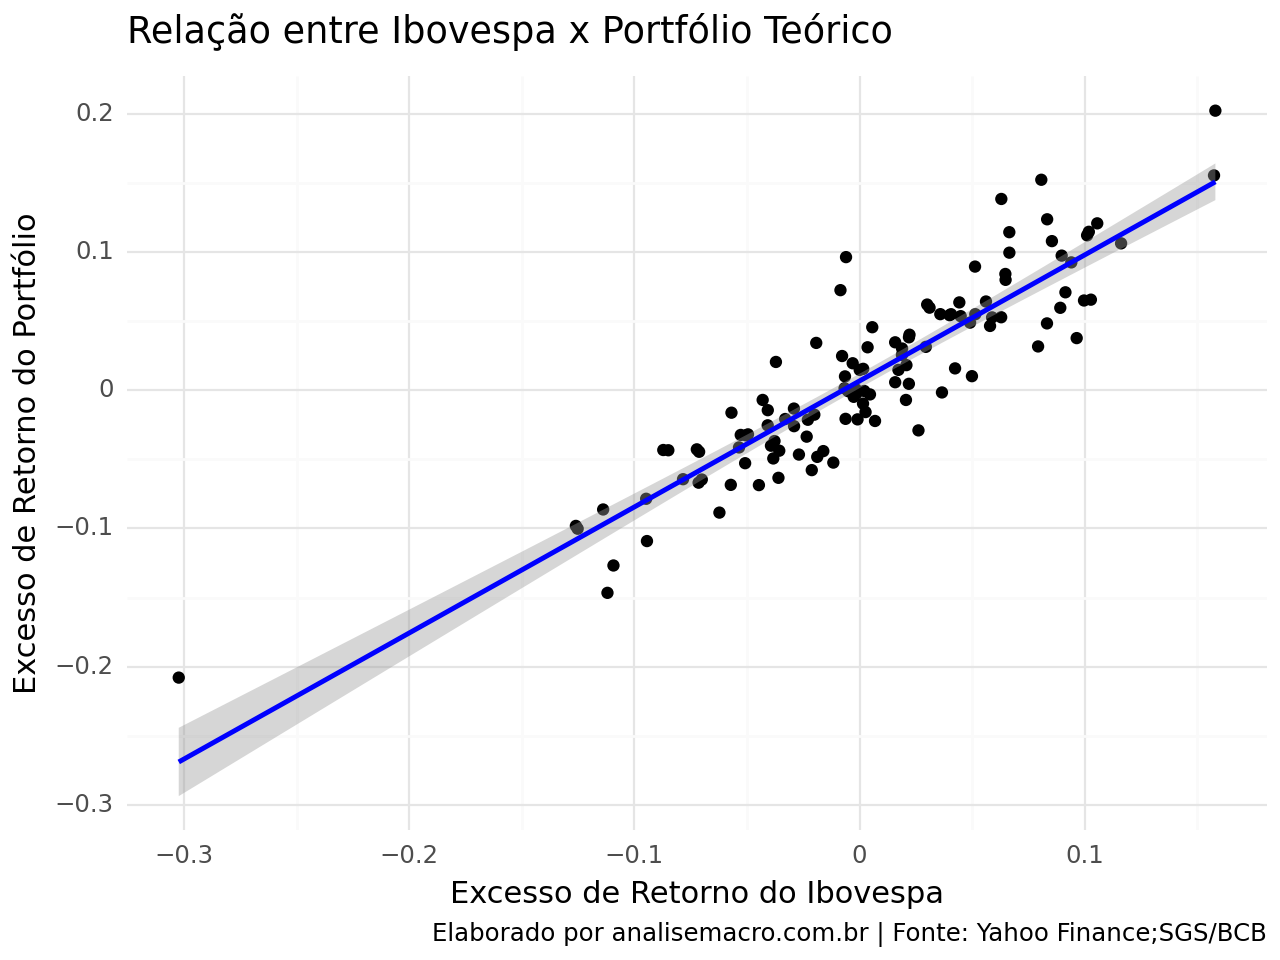

<Figure Size: (640 x 480)>

In [ ]:
# Cria um gráfico de dispersão com reta de regressão
(ggplot(portfolio, aes(x = 'excesso_ibovespa', y = 'excesso_retorno'))
 + geom_point()
 + stat_smooth(method = 'lm', color = 'blue')
 + labs(title = 'Relação entre Ibovespa x Portfólio Teórico', x = 'Excesso de Retorno do Ibovespa', y = 'Excesso de Retorno do Portfólio', caption = 'Elaborado por analisemacro.com.br | Fonte: Yahoo Finance;SGS/BCB')
 + theme_minimal())

# Beta Móvel

In [ ]:
# Cria função para estimar o beta móvel
def roll_capm_estimation(data, window_size, min_obs):

    result = (RollingOLS.from_formula(
      formula = "excesso_retorno ~ excesso_ibovespa",
      data = data,
      window = window_size,
      min_nobs = min_obs
      )
      .fit()
      .params["excesso_ibovespa"]
    )

    result.index = data.index
    result = pd.DataFrame(result).rename({'excesso_ibovespa' : 'beta'}, axis = 1)
    return result

In [ ]:
# Estima o beta móvel em janelas de 60 meses
beta = roll_capm_estimation(data = portfolio, window_size = 60, min_obs = 48)

In [ ]:
# Realiza tratamento sobre o data frame
beta.reset_index(inplace = True)
beta.dropna(inplace = True)

beta

,Date,beta
59,2019-01-01,1.005570
60,2019-02-01,1.012386
61,2019-03-01,1.016042
62,2019-04-01,1.015379
63,2019-05-01,1.012395
64,2019-06-01,1.014555
65,2019-07-01,1.013564
66,2019-08-01,1.030532
67,2019-09-01,1.049032
68,2019-10-01,1.049230


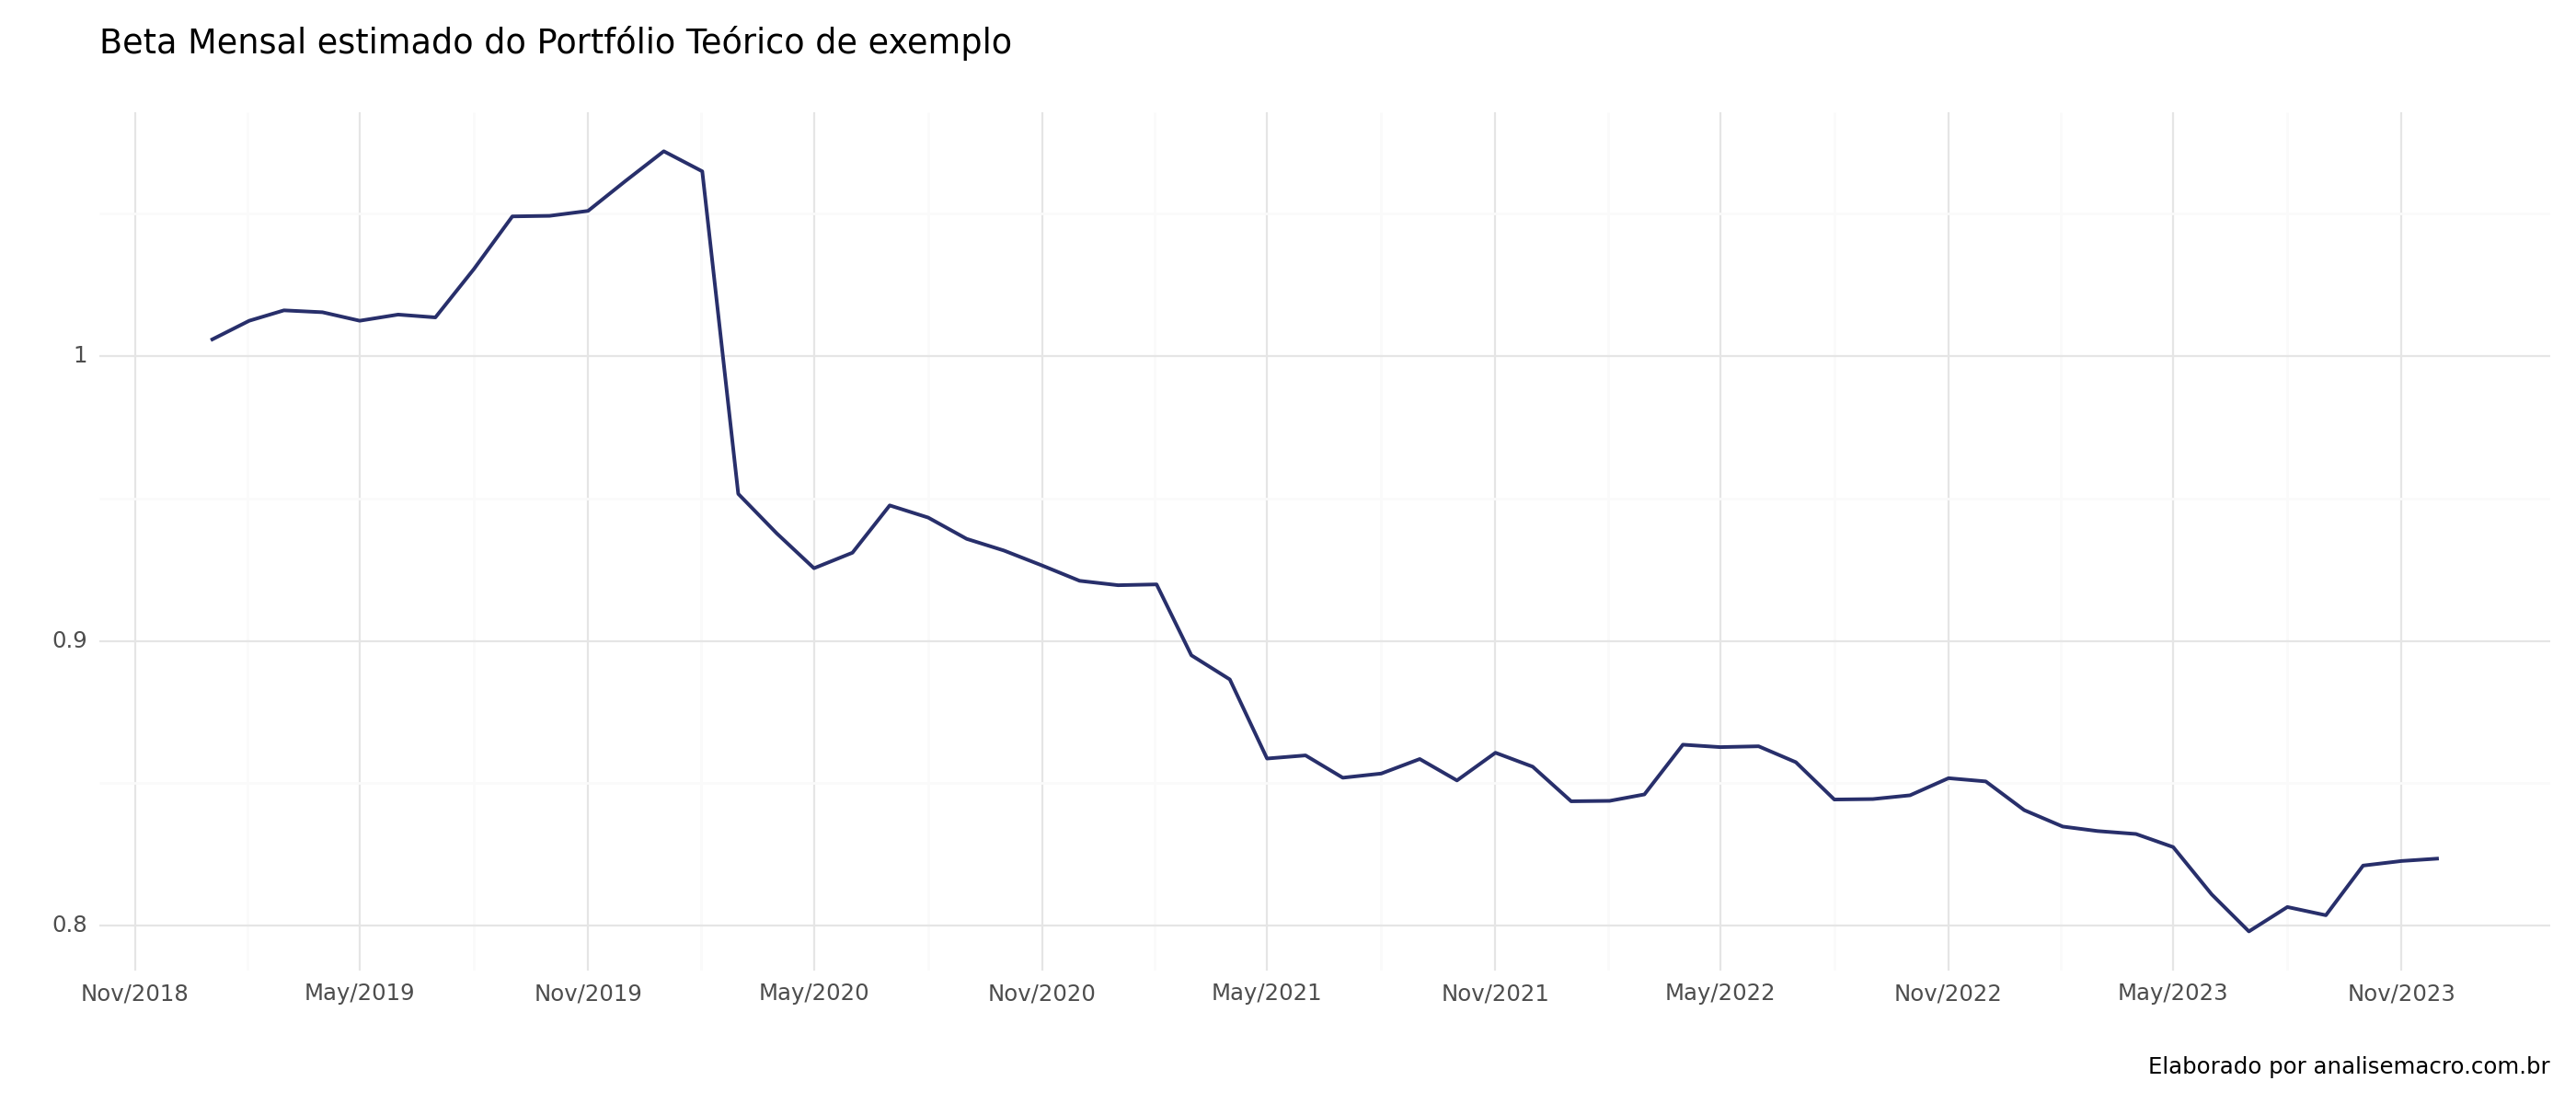

In [ ]:
# Cria o gráfico do Beta Móvel
plot_beta = (
  ggplot(beta,
         aes(x = "Date", y = "beta")) +
  geom_line(size = 0.8, color = '#282f6b') +
  scale_x_datetime(breaks = date_breaks("6 month"),
                   labels = date_format("%b/%Y")) +
  labs(x = "",
       y = "",
       title = ("Beta Mensal estimado do Portfólio Teórico de exemplo"),
       caption = 'Elaborado por analisemacro.com.br'
  ) +
   theme_minimal() +
   theme(figure_size = (14, 6))
)

plot_beta.draw()